how we can run workflows in parallel and get combines results 
story + poem + joke

In [13]:
## create a llm model
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x117e665d0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x117e65010>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [14]:
## define state

from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
class State(TypedDict):
      topic: str
      joke: str
      story: str
      poem: str
      combined_output: str

In [20]:
## define nodes

def writeJoke(state: State):
    msg = llm.invoke(f"Write a joke about {state['topic']}",)
    return {"joke": msg.content}
def writeStory(state: State) -> State:
    msg = llm.invoke(f"Write a story about {state['topic']}",)
    return {"story": msg.content}
def writePoem(state: State) -> State:
    msg = llm.invoke(f"Write a poem about {state['topic']}",)
    return {"poem": msg.content}
def combine(state: State) -> State:
    msg = llm.invoke(f"Combine the following into a single output:\n\nJoke: {state['joke']}\n\nStory: {state['story']}\n\nPoem: {state['poem']}",)
    return {"combined_output": msg.content}

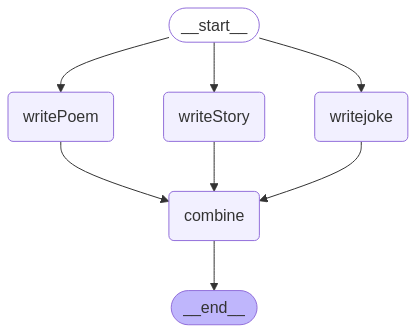

In [25]:
workflow = StateGraph(State)

workflow.add_node("writejoke", writeJoke)
workflow.add_node("writeStory", writeStory)
workflow.add_node("writePoem", writePoem)
workflow.add_node("combine", combine)
workflow.add_edge(START, "writejoke")
workflow.add_edge(START, "writeStory")
workflow.add_edge(START, "writePoem")
workflow.add_edge("writejoke", "combine")
workflow.add_edge("writeStory", "combine")
workflow.add_edge("writePoem", "combine")
workflow.add_edge("combine", END)

workflow.compile()

In [26]:
graph=workflow.compile()
graph.invoke({"topic":"cats"})

{'topic': 'cats',
 'joke': "Why don't cats play poker in the jungle? \n\nToo many cheetahs! 😹  \n",
 'story': 'Bartholomew Buttons, a ginger tabby with a crooked tail, surveyed his kingdom from atop the bookshelf. His emerald eyes, twin points of molten gold in the dappled sunlight, observed the three other inhabitants: Penelope, a sleek black cat with a penchant for mischief; Jasper, a fluffy Persian with an air of perpetual disdain; and Clementine, a calico elder who, despite her age, still possessed a surprising amount of spunk.\n\nBartholomew, or Bart as he preferred, was the self-proclaimed leader, a title mostly unchallenged thanks to his cunning and strategic naps in prime sunbeams. Today, however, a sense of unease prickled his whiskers. Penelope, usually a whirlwind of playful chaos, sat listlessly by the window, her gaze fixed on the bustling street below.\n\n"What troubles you, Penelope?" Bart inquired, his voice a low rumble.\n\nPenelope sighed, a sound like wind through dr